# Use the `transformer-monte-carlo` library

The goal of this notebook is to replicate what has been shown in the notebook 2 in this folder, this time using the library [`transformer-monte-carlo`](https://gitlab.com/francesco-calcavecchia/transformer-monte-carlo).
Thanks to the "professionalization" of the code, we will now try to push the computation accuracy, and be more quantitative about the results.

However, in doing this, we realised a major difficulty in the optimization that will force us to revisit the whole approach. What we have just anticipated here will become clear reading further in this notebook.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import math
import matplotlib.pyplot as plt
from transformer_monte_carlo.loss import compute_tmc_loss
from transformer_monte_carlo.estimation import compute_tmc_estimations
from transformer_monte_carlo.transformed_estimation import compute_transformed_estimations
from transformer_monte_carlo.swarm import TMCSwarm
from transformer_monte_carlo.transformation_model import TMCTransformationModel

First of all we define the functions for our usual integral
$$
\int dx \, \frac{e^{-x^2}}{\sqrt{\pi}} \cos(20 \, x)
$$

Notice that we will use [`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function) to make the program computationally more efficient.

In [2]:
rho_pdf = tfp.distributions.Normal(loc=0., scale=1.)

@tf.function
def rho(x: tf.Tensor) -> tf.Tensor:
    return rho_pdf.prob(x)

In [3]:
k = 20.

@tf.function
def g(x: tf.Tensor) -> tf.Tensor:
    return tf.cos(tf.constant(k) * x)

We sample `Nmc` points from the gaussian distribution, compute the corresponding estimates by applying the `g` function

In [4]:
Nmc = 1000000
x = rho_pdf.sample((Nmc, 1))
g_values = g(x)

and then split them in a training and test set. The training set will be used to optimize the neural networks (using the [Adam algorithm](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?hl=en)). The test set will be used by the `transformer-monte-carlo` Swarm to evaluate the loss of the neural networks, and choose which one to prune.

In [5]:
x_train, x_test = tf.split(x, [Nmc*8//10, Nmc*2//10])
x_train.shape, x_test.shape

(TensorShape([800000, 1]), TensorShape([200000, 1]))

In [6]:
g_values_train, g_values_test = tf.split(g_values, [Nmc*8//10, Nmc*2//10])
g_values_train.shape, g_values_test.shape

(TensorShape([800000, 1]), TensorShape([200000, 1]))

For reference, let's compute the loss of the naive approach:

In [7]:
compute_tmc_loss(g_values_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.50091237>

We now introduce some convenience functions that will make easier to optimize the swarms of neural networks of different size (always single hidden layer).

In [8]:
optimizer = tf.keras.optimizers.Adam()

In [9]:
def get_ffnn(size=15):
    return tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=size, input_shape=(1,), activation=tf.keras.activations.tanh),
        tf.keras.layers.Dense(units=1, activation=tf.keras.activations.tanh),
        tf.keras.layers.Dense(units=1, activation=tf.keras.activations.linear)])

In [10]:
def print_swarm_losses(swarm):
    losses = swarm.evaluate(x_test, g_values_test)
    losses_as_simple_list_of_floats = [l.numpy() for l in losses]
    print('losses =', losses_as_simple_list_of_floats)

In [11]:
def optimize_swarm(model_size, n_models, batch_sizes, epochs, prune_n_models):
    tf.random.set_seed(42)
    swarm = TMCSwarm(models=[get_ffnn(size=model_size) for _ in range(n_models)], rho=rho, g=g)
    print_swarm_losses(swarm)
    for bs, e, nm in zip(batch_sizes, epochs, prune_n_models):
        swarm.optimize(x_train, g_values_train, optimizer, bs, e)
        swarm.prune(nm, x_test, g_values_test)
        print_swarm_losses(swarm)
    return swarm

### Neural network of size 3

In [12]:
swarm_3 = optimize_swarm(model_size=3, 
                         n_models=30, 
                         batch_sizes=[1000, 2500, 5000, 10000, 10000, 25000], 
                         epochs=[1, 5, 10, 20, 100, 100], 
                         prune_n_models=[15, 10, 5, 3, 1, 1])

losses = [0.18364666, 0.55183494, 3.0189955, 0.2756225, 0.15289325, 0.1388545, 0.13332665, 0.3476857, 0.21723683, 0.20319511, 0.14593838, 0.105342716, 0.121640556, 0.20268035, 0.34994784, 0.39270392, 0.21734028, 0.12839825, 0.27093634, 0.12560117, 0.12591356, 0.18765332, 0.15430953, 0.17944361, 0.3022412, 1.1733298, 0.14480822, 0.30194044, 0.099712774, 0.26074535]
losses = [0.0884075, 0.08941879, 0.089912735, 0.090615325, 0.09149416, 0.09262875, 0.09582033, 0.09697814, 0.12361619, 0.12522729, 0.12522794, 0.12522806, 0.12522836, 0.12522839, 0.12522854]


/Users/francescocalcavecchia/Code/Physics/DeepTwinSamplingMonteCarlo/deeptwinsamplingmontecarlo-notebooks/2020-12-16-optimiza_nn_transformation/venv/lib/python3.8/site-packages/transformer_monte_carlo/swarm.py:76: UserWarning: Model 9 raised an exception during the optimization and will therefore be removed from the swarm. The error was: Input is not invertible. [Op:MatrixInverse]
  warnings.warn(f'Model {i} raised an exception during the optimization and will therefore be removed from the swarm. '
/Users/francescocalcavecchia/Code/Physics/DeepTwinSamplingMonteCarlo/deeptwinsamplingmontecarlo-notebooks/2020-12-16-optimiza_nn_transformation/venv/lib/python3.8/site-packages/transformer_monte_carlo/swarm.py:76: UserWarning: Model 13 raised an exception during the optimization and will therefore be removed from the swarm. The error was: Input is not invertible. [Op:MatrixInverse]
  warnings.warn(f'Model {i} raised an exception during the optimization and will therefore be removed from the 

losses = [0.08623989, 0.08926557, 0.08966404, 0.08997375, 0.09012788, 0.09069207, 0.09166224, 0.09186868, 0.101751894, 0.12522806]
losses = [0.086009726, 0.08927955, 0.08951039, 0.089688554, 0.089960545]
losses = [0.086171426, 0.08921178, 0.08921703]


/Users/francescocalcavecchia/Code/Physics/DeepTwinSamplingMonteCarlo/deeptwinsamplingmontecarlo-notebooks/2020-12-16-optimiza_nn_transformation/venv/lib/python3.8/site-packages/transformer_monte_carlo/swarm.py:76: UserWarning: Model 0 raised an exception during the optimization and will therefore be removed from the swarm. The error was: Input is not invertible. [Op:MatrixInverse]
  warnings.warn(f'Model {i} raised an exception during the optimization and will therefore be removed from the swarm. '
/Users/francescocalcavecchia/Code/Physics/DeepTwinSamplingMonteCarlo/deeptwinsamplingmontecarlo-notebooks/2020-12-16-optimiza_nn_transformation/venv/lib/python3.8/site-packages/transformer_monte_carlo/swarm.py:76: UserWarning: Model 1 raised an exception during the optimization and will therefore be removed from the swarm. The error was: Input is not invertible. [Op:MatrixInverse]
  warnings.warn(f'Model {i} raised an exception during the optimization and will therefore be removed from the s

losses = [0.012053497]
losses = [0.0033857366]


In [13]:
swarm_3.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_3)

losses = [0.00091686647]


In [14]:
swarm_3.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_3)

losses = [0.00033362934]


### Neural network of size 4

In [15]:
swarm_4 = optimize_swarm(model_size=4, 
                         n_models=30, 
                         batch_sizes=[1000, 2500, 5000, 10000, 10000, 25000], 
                         epochs=[1, 5, 10, 20, 100, 100], 
                         prune_n_models=[15, 10, 5, 3, 1, 1])

losses = [0.13957322, 14.67716, 4.906316, 2.047642, 0.33387962, 0.1377244, 1.355224, 0.21604784, 3.4283557, 0.20364884, 0.15253195, 0.25120434, 0.34897313, 0.21013252, 0.14233156, 1.7948511, 0.82381296, 0.13393594, 0.2668103, 0.12555231, 0.14199679, 0.16136001, 0.23291074, 0.62510324, 0.3118525, 0.9287423, 0.46741593, 0.6457251, 0.14800778, 0.4737595]


/Users/francescocalcavecchia/Code/Physics/DeepTwinSamplingMonteCarlo/deeptwinsamplingmontecarlo-notebooks/2020-12-16-optimiza_nn_transformation/venv/lib/python3.8/site-packages/transformer_monte_carlo/swarm.py:76: UserWarning: Model 26 raised an exception during the optimization and will therefore be removed from the swarm. The error was: Input is not invertible. [Op:MatrixInverse]
  warnings.warn(f'Model {i} raised an exception during the optimization and will therefore be removed from the swarm. '


losses = [0.08991179, 0.09043574, 0.09113043, 0.091912724, 0.09211518, 0.09212814, 0.09379043, 0.12522802, 0.12522838, 0.1252284, 0.12522845, 0.12523118, 0.12523133, 0.12527414, 0.12557633]
losses = [0.08902246, 0.08903438, 0.090020135, 0.09009732, 0.09028467, 0.09151984, 0.092220575, 0.12522808, 0.12522817, 0.12522827]
losses = [0.088534765, 0.08865119, 0.08978921, 0.089979894, 0.090161234]
losses = [0.088057555, 0.08850582, 0.0885265]


/Users/francescocalcavecchia/Code/Physics/DeepTwinSamplingMonteCarlo/deeptwinsamplingmontecarlo-notebooks/2020-12-16-optimiza_nn_transformation/venv/lib/python3.8/site-packages/transformer_monte_carlo/swarm.py:76: UserWarning: Model 2 raised an exception during the optimization and will therefore be removed from the swarm. The error was: Input is not invertible. [Op:MatrixInverse]
  warnings.warn(f'Model {i} raised an exception during the optimization and will therefore be removed from the swarm. '


losses = [0.084966615]
losses = [0.08390779]


In [16]:
swarm_4.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_4)

losses = [0.083292834]


In [17]:
swarm_4.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_4)

losses = [0.07511714]


In [18]:
swarm_4.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_4)

losses = [0.05320807]


In [19]:
swarm_4.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_4)

losses = [0.053242814]


### Neural network of size 5

In [20]:
swarm_5 = optimize_swarm(model_size=5, 
                         n_models=30, 
                         batch_sizes=[1000, 2500, 5000, 10000, 10000, 25000], 
                         epochs=[1, 5, 10, 20, 100, 100], 
                         prune_n_models=[15, 10, 5, 3, 1, 1])

losses = [0.1667549, 4.5502963, 0.51659554, 1.3592328, 0.3885164, 0.14380535, 0.17524965, 0.23950511, 1.0743065, 0.16128995, 0.12615246, 0.21958, 0.1733167, 0.84318984, 0.14183621, 2.9368637, 1.8416442, 0.13223383, 0.13439074, 0.12726828, 0.12956257, 0.14503956, 0.1897443, 0.14990725, 0.31726557, 1.1659179, 0.313529, 1.0704958, 0.17347562, 0.8000253]
losses = [0.08973686, 0.09048648, 0.09065973, 0.091981836, 0.0973557, 0.11313781, 0.119300604, 0.12522726, 0.12522735, 0.12522769, 0.12522833, 0.12522835, 0.12523076, 0.1252312, 0.12529935]
losses = [0.08825986, 0.08968553, 0.08992838, 0.09109701, 0.09262617, 0.09441588, 0.09925306, 0.12522534, 0.12522642, 0.12522769]


/Users/francescocalcavecchia/Code/Physics/DeepTwinSamplingMonteCarlo/deeptwinsamplingmontecarlo-notebooks/2020-12-16-optimiza_nn_transformation/venv/lib/python3.8/site-packages/transformer_monte_carlo/swarm.py:76: UserWarning: Model 4 raised an exception during the optimization and will therefore be removed from the swarm. The error was: Input is not invertible. [Op:MatrixInverse]
  warnings.warn(f'Model {i} raised an exception during the optimization and will therefore be removed from the swarm. '


losses = [0.0879459, 0.088115655, 0.0895443, 0.08994684, 0.08999587]
losses = [0.08749746, 0.087601855, 0.08991299]
losses = [0.004458499]
losses = [0.0016706642]


In [21]:
swarm_5.optimize(x_train, g_values_train, optimizer, 25000, 100)
swarm_5.evaluate(x_test, g_values_test)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0005954056>]

In [22]:
swarm_5.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_5)

losses = [0.00021243784]


In [23]:
swarm_5.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_5)

losses = [0.0001432108]


In [24]:
swarm_5.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_5)

losses = [0.00011012447]


### Neural network of size 6

In [25]:
swarm_6 = optimize_swarm(model_size=6, 
                         n_models=30, 
                         batch_sizes=[1000, 2500, 5000, 10000, 10000, 25000], 
                         epochs=[1, 5, 10, 20, 100, 100], 
                         prune_n_models=[15, 10, 5, 3, 1, 1])

losses = [1.0681667, 0.9500473, 0.3597739, 1.1270244, 0.24238105, 0.13901494, 0.21365887, 0.09883789, 0.13696279, 0.15704076, 0.12562683, 0.17631732, 0.129453, 0.7548491, 0.14256352, 0.39542082, 0.5391618, 0.12564802, 0.091247596, 0.125583, 0.12530261, 0.13935493, 0.2364647, 1.3070129, 0.3229773, 1.539975, 0.3158212, 0.21219905, 0.26437175, 0.32131898]
losses = [0.07854024, 0.08911387, 0.08987541, 0.089936234, 0.08997493, 0.09106014, 0.091117226, 0.091599114, 0.09285764, 0.09366268, 0.0942716, 0.1252267, 0.12522797, 0.12522812, 0.12522838]
losses = [0.049922474, 0.08755684, 0.08830108, 0.08915585, 0.089475624, 0.08949387, 0.089961804, 0.09034268, 0.09137026, 0.09182764]
losses = [0.048848517, 0.08681777, 0.08717435, 0.08887099, 0.08913038]
losses = [0.048208915, 0.085733116, 0.08704141]
losses = [0.043366108]
losses = [0.042273086]


In [26]:
swarm_6.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_6)

losses = [0.032109678]


In [27]:
swarm_6.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_6)

losses = [0.031522118]


In [28]:
swarm_6.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_6)

losses = [0.030413296]


### Neural network of size 10

In [29]:
swarm_10 = optimize_swarm(model_size=10, 
                         n_models=30, 
                         batch_sizes=[1000, 2500, 5000, 10000, 10000, 25000], 
                         epochs=[1, 5, 10, 20, 100, 100], 
                         prune_n_models=[15, 10, 5, 3, 1, 1])

losses = [0.54691786, 0.45849267, 5.6439686, 7.8667054, 0.14293131, 0.14105333, 0.20415813, 0.1832982, 0.2533438, 0.13738033, 0.12547055, 0.19035101, 0.18559872, 0.32827967, 0.9631346, 2.3945441, 0.6651844, 0.13304281, 0.091639645, 0.13376947, 0.12584998, 0.13632354, 0.16074914, 0.8392559, 0.65304834, 2.5643222, 0.26191002, 0.23171543, 0.16183639, 0.1941359]
losses = [0.08887268, 0.08919371, 0.08969502, 0.0897406, 0.089869015, 0.090437315, 0.0916965, 0.09190458, 0.09213737, 0.092346326, 0.09603789, 0.12522693, 0.12522754, 0.12522812, 0.12522905]
losses = [0.052660763, 0.05488327, 0.08824882, 0.08885676, 0.08890971, 0.08896838, 0.089115694, 0.08935706, 0.08953633, 0.090278044]
losses = [0.040454973, 0.044805646, 0.087770514, 0.08855375, 0.08867301]
losses = [0.037169788, 0.038846713, 0.087457776]
losses = [0.030314248]
losses = [0.029374223]


In [30]:
swarm_10.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_10)

losses = [0.024947947]


In [31]:
swarm_10.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_10)

losses = [0.013118634]


In [32]:
swarm_10.optimize(x_train, g_values_train, optimizer, 25000, 100)
print_swarm_losses(swarm_10)

losses = [0.01294599]


### Summarize results

In [33]:
nn_size = [3, 4, 5, 6, 10]
loss = list(tf.convert_to_tensor([swarm.evaluate(x=x_test, g_values=g_values_test)[0] 
                                  for swarm in [swarm_3, swarm_4, swarm_5, swarm_6, swarm_10]]).numpy())

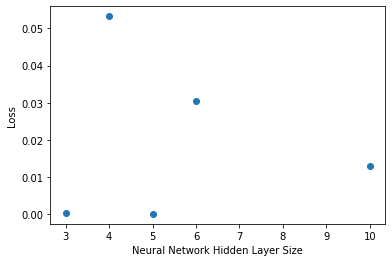

In [34]:
plt.scatter(nn_size, loss)
plt.xlabel('Neural Network Hidden Layer Size')
plt.ylabel('Loss')
plt.show()

Notice that there is quite some noise in the results. However, the best result is obtained with the swarm of networks of size 5. 

In [50]:
best_model = swarm_5.tmc_models[0]

We plot the optimized neural network transformations for size 3 and 5:

In [59]:
def plot_nn_transformation(nn):
    span = np.arange(-4., 4., 0.1)
    plt.figure(figsize=(4, 4))
    plt.scatter(x=span, y=(nn.predict([x for x in span])))
    plt.plot(span, span, linestyle='--', linewidth=1.5)
    plt.plot(span, -span, linestyle='--', linewidth=1.5, color='orange')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$n(x)$')
    plt.legend([r'$x$', r'$-x$', r'$n(x)$'])
    plt.axvline(x=-2.7, ymin=-4, ymax=3, color='grey', linestyle=':', linewidth=1.)
    plt.axvline(x=2.1, ymin=-4, ymax=3, color='grey', linestyle=':', linewidth=1.)
    plt.show()

#### Size 3

In [103]:
plot_nn_transformation(swarm_3.tmc_models[0].model)

#### Size 5

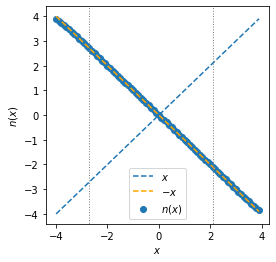

In [105]:
plot_nn_transformation(swarm_5.tmc_models[0].model)

Very interestingly, they both how a shape similar to the one we have found in the notebook 2 in this folder. However, at this point, the computation is more precise, and we can clearly see that the transformation looks very much like $x \mapsto -x$.

Analytically this transformation would lead to
$$
g_t = - g(x)
$$
because $\rho$ and $g$ are symmetrical, and $t^{\prime}(x) = -1$.

Then, if we compute the Transformer Monte Carlo estimations with weights $\frac{1}{2}$, i.e.
$$
I_{\text{TMC}} = \sum_{x_i} \frac{g(x_i) + g_t(x_i)}{2}
$$
it is clear that $I_{\text{TMC}} = 0$ and the loss is zero.

**The neural network found the best transformation to minimize the loss, however this is a spurious result coming from a wrongly formulated optimization problem.**

We can demonstrate our claim empirically by defining such transformation and computing the loss.

In [108]:
g_minus_x = compute_transformed_estimations(
    model=lambda x: -x,
    rho=rho,
    g=g,
    x=x_test,
)
tmc_estimations_minus_x = compute_tmc_estimations(g_minus_x,
                                          g_values_test)
compute_tmc_loss(tmc_estimations_minus_x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

# Conclusion

We have found out that optimizing a neural network as done here leads to spurious results. 

We must revisit the Transformer Monte Carlo approach and better tune the optimization problem.